Oriented Keypoints:
X: 345, Y: 69, Orientation: 180.0 degrees
X: 353, Y: 69, Orientation: 44.990455627441406 degrees
X: 364, Y: 70, Orientation: 195.64462280273438 degrees
X: 369, Y: 70, Orientation: 261.8705139160156 degrees
X: 379, Y: 70, Orientation: 141.34251403808594 degrees
X: 403, Y: 69, Orientation: 0.0 degrees
X: 359, Y: 75, Orientation: 161.5613250732422 degrees
X: 365, Y: 76, Orientation: 0.24905769526958466 degrees
X: 374, Y: 76, Orientation: 119.40573120117188 degrees
X: 384, Y: 75, Orientation: 184.263427734375 degrees
X: 370, Y: 80, Orientation: 42.4063835144043 degrees
X: 379, Y: 80, Orientation: 142.59996032714844 degrees
X: 365, Y: 81, Orientation: 340.37359619140625 degrees
X: 368, Y: 85, Orientation: 145.96115112304688 degrees
X: 375, Y: 86, Orientation: 255.96221923828125 degrees
X: 380, Y: 85, Orientation: 229.8277130126953 degrees
X: 371, Y: 91, Orientation: 135.00955200195312 degrees
X: 380, Y: 90, Orientation: 322.1293640136719 degrees
X: 389, Y: 99, Orientatio

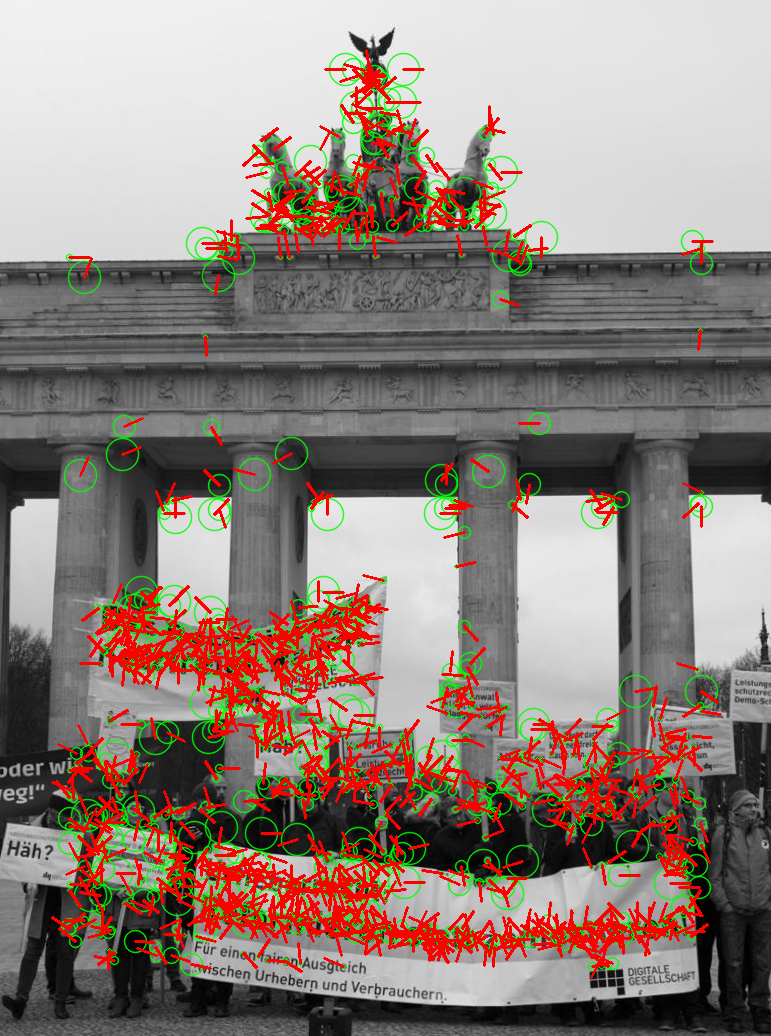

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


def scale_space_peak_selection(image):
    scale_space = build_scale_space(image)
    keypoints = []


    for octave_index in range(len(scale_space)):
        for level in range(1, scale_space[octave_index].shape[0] - 1):
            neighbors = scale_space[octave_index][level - 1:level + 2, :, :]
            extremum_response = scale_space[octave_index][level, :, :] - np.max(neighbors, axis=0)
            extremum_locations = np.column_stack(np.where(extremum_response > 0))


            for location in extremum_locations:
                keypoints.append((octave_index, location[0], location[1]))


    return np.array(keypoints)


def build_scale_space(image, num_octaves=4, num_scales=5, sigma=1.6):
    scale_space = []


    for octave in range(num_octaves):
        octave_images = []


        if octave == 0:
            blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma)
        else:
            blurred = cv2.GaussianBlur(scale_space[octave - 1][0], (0, 0), sigmaX=sigma)


        octave_images.append(blurred)


        for _ in range(1, num_scales + 3):
            blurred = cv2.GaussianBlur(octave_images[-1], (0, 0), sigmaX=sigma)
            octave_images.append(blurred)


        scale_space.append(np.array(octave_images))
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2))


    return scale_space


def localize_keypoints(image, keypoints):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    # Create the STAR detector
    star = cv2.xfeatures2d.StarDetector_create()


    # Create the BRIEF extractor
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()


    # Detect keypoints with STAR
    kp = star.detect(gray, None)


    # Extract descriptors with BRIEF
    kp, des = brief.compute(gray, kp)


    # Get keypoint locations
    keypoint_locations = np.array([kp[idx].pt for idx in range(len(kp))], dtype=np.float32)


    # Draw keypoints on the image
    img_keypoints = cv2.drawKeypoints(image, kp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


    return img_keypoints, keypoint_locations


def assign_orientation(image, keypoints):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    # Compute gradients using Sobel operator
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)


    # Calculate gradient magnitude and angle
    magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)


    # Assign orientation to keypoints
    oriented_keypoints = []


    for keypoint in keypoints:
        x, y = int(keypoint[0]), int(keypoint[1])
        keypoint_angle = angle[y, x]
        oriented_keypoints.append((x, y, keypoint_angle))


    return oriented_keypoints


def compute_keypoint_descriptors_by_hand(image, keypoints, patch_size=9):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    descriptors = []


    for keypoint in keypoints:
        x, y = int(keypoint[0]), int(keypoint[1])


        # Ensure the patch is within image boundaries
        if x - patch_size // 2 >= 0 and x + patch_size // 2 < gray.shape[1] and y - patch_size // 2 >= 0 and y + patch_size // 2 < gray.shape[0]:
            patch = gray[y - patch_size // 2:y + patch_size // 2 + 1, x - patch_size // 2:x + patch_size // 2 + 1].flatten()


            # Create a binary descriptor
            descriptor = [1 if pixel >= patch.mean() else 0 for pixel in patch]


            descriptors.append(descriptor)


    return np.array(descriptors)


# Example usage
image = cv2.imread('image.jpg', cv2.IMREAD_COLOR)
keypoints = scale_space_peak_selection(image)
image_with_keypoints, refined_keypoint_locations = localize_keypoints(image, keypoints)
oriented_keypoints = assign_orientation(image, refined_keypoint_locations)


# Display the assigned orientations
print("Oriented Keypoints:")
for keypoint in oriented_keypoints:
    print(f"X: {keypoint[0]}, Y: {keypoint[1]}, Orientation: {keypoint[2]} degrees")


# Draw oriented keypoints on the image
for keypoint in oriented_keypoints:
    x, y = int(keypoint[0]), int(keypoint[1])
    angle = keypoint[2]
    cv2.line(image_with_keypoints, (x, y), (int(x + 20 * np.cos(np.radians(angle))), int(y + 20 * np.sin(np.radians(angle)))), (0, 0, 255), 2)


# Show the result with oriented keypoints
cv2_imshow(image_with_keypoints)

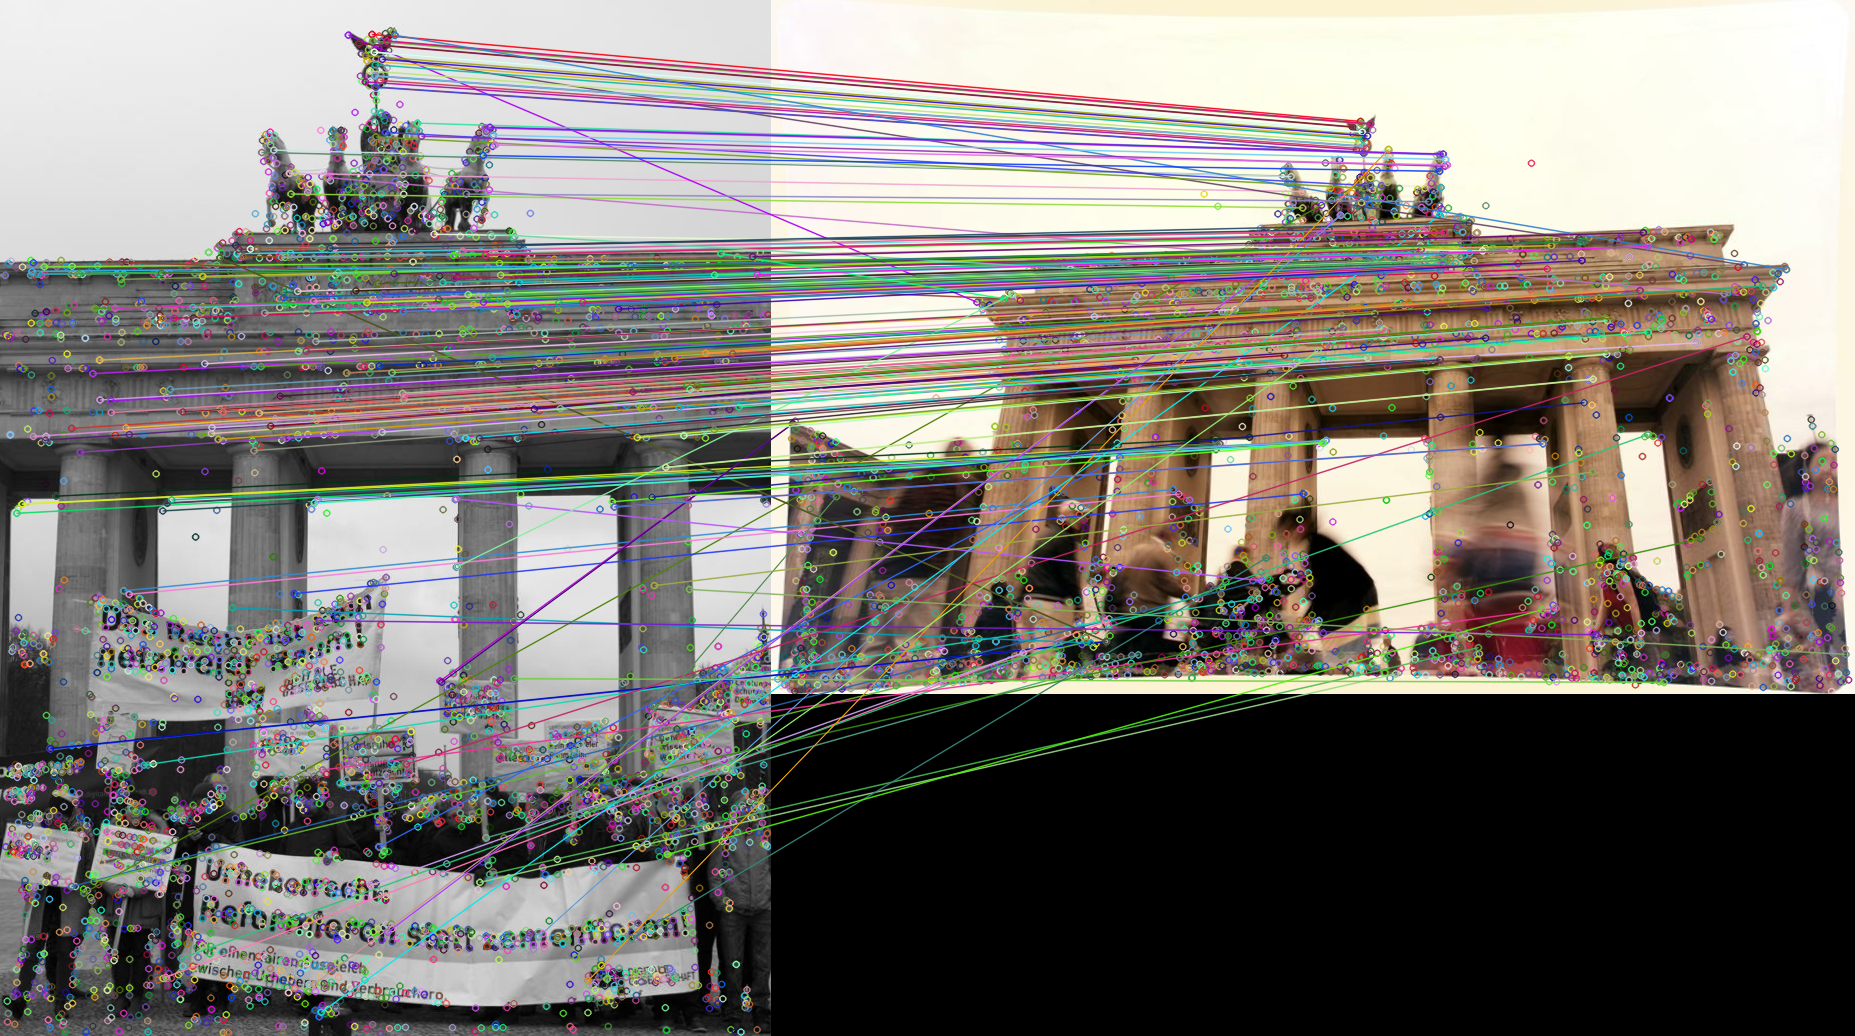

In [2]:
def match_keypoints(descriptors1, descriptors2, ratio_thresh=0.75):
    # Crear un objeto BFMatcher
    bf = cv2.BFMatcher()

    # Encontrar coincidencias de los dos conjuntos de descriptores
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Aplicar la prueba de relación de Lowe para filtrar coincidencias buenas
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    return good_matches

# Cargar dos imágenes (reemplaza con las rutas a tus imágenes)
image1 = cv2.imread('image.jpg')
image2 = cv2.imread('image1.jpg')

# Inicializar el detector y descriptor SIFT
sift = cv2.SIFT_create()

# Detectar y describir los puntos clave
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Realizar la coincidencia de puntos clave
good_matches = match_keypoints(descriptors1, descriptors2)

# Dibujar las coincidencias
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None)

# Mostrar la imagen con las coincidencias usando cv2_imshow
cv2_imshow(matched_image)
